In [1]:
import os
IN_KAGGLE = 'KAGGLE_URL_BASE' in os.environ
IN_KAGGLE

False

In [2]:
if IN_KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value = user_secrets.get_secret("gittoken2")
    !git clone https://{secret_value}@github.com/moienr/CropMapping.git

In [3]:
if IN_KAGGLE:
    import time
    import os
    sleep_time = 5
    while not os.path.exists("/kaggle/working/CropMapping"):
        print("didn't find the path, wating {sleep_time} more seconds...")
        time.sleep(sleep_time)
    print("path found...")
    import sys
    sys.path.append("/kaggle/working/CropMapping")
    sys.path.append("/kaggle/working/CropMapping/dataset")

In [4]:
import torch
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
torch.__version__

'1.13.1'

In [6]:
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
from glob import glob
from skimage import io
import os
from torchvision import datasets, transforms
import matplotlib
import os
import gc
import random
from datetime import date, datetime
import json
import pprint
os.cpu_count()

20

In [7]:
import importlib
import train_utils
importlib.reload(train_utils)

<module 'train_utils' from 'd:\\python\\CropMapping\\train_utils.py'>

In [8]:
from model.model import DualUNet3D, IranCropModel
from train_utils import train, binary_mask_accuracy, calculate_dataset_metrics
from config import DEVICE
from plot import plot_output_crop_map, plot_s2_img

In [9]:
DEVICE

'cuda'

In [10]:
# from dataset.data_loaders import *
# from dataset.utils.utils import TextColors as TC
# from dataset.utils.plot_utils import plot_s1s2_tensors, save_s1s2_tensors_plot
# #from config import *
# from train_utils import *

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import random_split

In [12]:
# from dataset.data_loaders import *
import dataset.data_loaders as dl
from plot import plot_train_test_losses

In [13]:
s1_transform = transforms.Compose([dl.NormalizeS1(),dl.myToTensor(dtype=torch.float32)])
s2_transform = transforms.Compose([dl.NormalizeS2(),dl.myToTensor(dtype=torch.float32)])
augmentation = dl.Augmentations()

In [14]:
CROP_LIST = ["canola", "cotton", "lentils", "maize", "onion", "pea", "sugarbeet", "tomato"]

In [18]:
# Train Paths
if IN_KAGGLE:
#     dirs = ["/kaggle/input/irandatastpeav1/"]
    dirs = ["/kaggle/input/irandatasetmaizev1/"]
else:
    dirs = ["D:/Datasets/crop_map_dataset_Iran_tomato/"]
    
if len(dirs) != len(CROP_LIST):
    raise Exception("Number of directories and crops should be the same.")

s1_dirs = [dir + "s1/" for dir in dirs]
s2_dirs = [dir + "s2/" for dir in dirs]
crop_map_dirs = [dir + "crop_map/" for dir in dirs]

In [24]:
train_dataset_list = []
valid_dataset_list = []
for i ,dirs in enumerate(zip(s1_dirs,s2_dirs,crop_map_dirs)):
    # if there is only one crop in the dataset, outpus is a binary mask, otherwise it is a one-hot encoded mask.
    crop_map_transform = transforms.Compose([
            dl.CropMapTransformIran(crop_type=CROP_LIST[i]) if len(dirs) != 1 else dl.CropMapTransformIran(),
            dl.myToTensor(dtype=torch.float32)
                                            ])
    
    dataset = dl.Sen12Dataset(s1_dir=dirs[0],
                            s2_dir=dirs[1],
                            crop_map_dir=dirs[2],
                            s1_transform=s1_transform,
                            s2_transform=s2_transform,
                            crop_map_transform=crop_map_transform,
                            augmentation=augmentation,
                            verbose=False)
    dataset_tarin_split, dataset_valid_split = random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])
    train_dataset_list.append(dataset_tarin_split)
    valid_dataset_list.append(dataset_valid_split)
    
if len(train_dataset_list) == 1:
    train_dataset = train_dataset_list[0]
    valid_dataset = valid_dataset_list[0]
else:
    train_dataset = ConcatDataset(train_dataset_list)
    valid_dataset = ConcatDataset(valid_dataset_list)


In [25]:
len(train_dataset), len(valid_dataset)

(16832, 4216)

In [26]:
print(train_dataset[0][0].shape, train_dataset[0][1].shape, train_dataset[0][2].shape)
print(valid_dataset[0][0].shape, valid_dataset[0][1].shape, valid_dataset[0][2].shape)


torch.Size([2, 6, 64, 64]) torch.Size([10, 6, 64, 64]) torch.Size([1, 64, 64])
torch.Size([2, 6, 64, 64]) torch.Size([10, 6, 64, 64]) torch.Size([1, 64, 64])


In [27]:
BATCH_SIZE = 16 if IN_KAGGLE else 4

In [28]:
train_sampler = dl.BalancedSampler(train_dataset, ratio=0.00, shuffle=True)

In [29]:
test_sampler = dl.BalancedSampler(valid_dataset, ratio=0.00, shuffle=False)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, sampler=train_sampler)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2, sampler=test_sampler)

In [31]:
len(train_loader), len(valid_loader)

(41, 10)

In [32]:
if IN_KAGGLE:
    dualunet3d_dict_path = "/kaggle/input/eu-5-epoch-train/StateDict_epoch11_EU.pth"
else:
    dualunet3d_dict_path = "model\StateDict_epoch11_EU.pth"

In [33]:
dualunet3d_dict = torch.load(dualunet3d_dict_path)
dualunet3d = DualUNet3D(s1_in_channels=2, s2_in_channels=10, out_channels=21,ts_depth=6,non_lin='sigmoid').to(DEVICE)
dualunet3d.load_state_dict(dualunet3d_dict)
model = IranCropModel(out_channels=len(CROP_LIST), dualunet3d=dualunet3d, non_lin=nn.Sigmoid()).to(DEVICE)

In [37]:
# Example usage
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
scheduler_type = "constant"  # Options: "constant", "step", "plateau". Choose which scheduler to use.

if scheduler_type == "step":
    step_size = 5
    gamma = 0.2
    scheduler_kwargs = {"step_size": step_size, "gamma": gamma}
elif scheduler_type == "plateau":
    factor = 0.5
    patience = 3
    scheduler_kwargs = {"factor": factor, "patience": patience}
else:
    scheduler_kwargs = {}

NUM_EPOCH = 5



In [38]:
# Get the parameters of the final_conv layer
final_conv_params = model.final_conv.parameters()

# Get the parameters of all other layers
other_params = [param for name, param in model.named_parameters() if 'final_conv' not in name]

# Create the optimizer
optimizer = torch.optim.Adam([
    {'params': final_conv_params, 'lr': 1e-4},
    {'params': other_params, 'lr': 1e-5}
])

In [39]:
results = train(model, train_loader, valid_loader, criterion, optimizer, scheduler_type, NUM_EPOCH, **scheduler_kwargs)

Training: 100%|██████████| 5/5 [01:46<00:00, 21.36s/epoch, Epoch=5, Train Loss=0.506, Validation Loss=0.504]


In [40]:
save_dir = "./model/saved_models/"
# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

torch.save(model, f"{save_dir}DualUNet3D_epoch{NUM_EPOCH}_Tomato.pth")
torch.save(model.state_dict(), f"{save_dir}StateDict_epoch{NUM_EPOCH}_Tomato.pth")
# torch.save(optimizer.state_dict(), f"./model/saved_models/Optimizer_epoch{NUM_EPOCH}_Tomato.pth")

In [41]:
# list to array with shape (1, len(list))
train_loss_history = np.array(results["train_loss_history"]).reshape(1, -1)
val_loss_history = np.array(results["val_loss_history"]).reshape(1, -1)

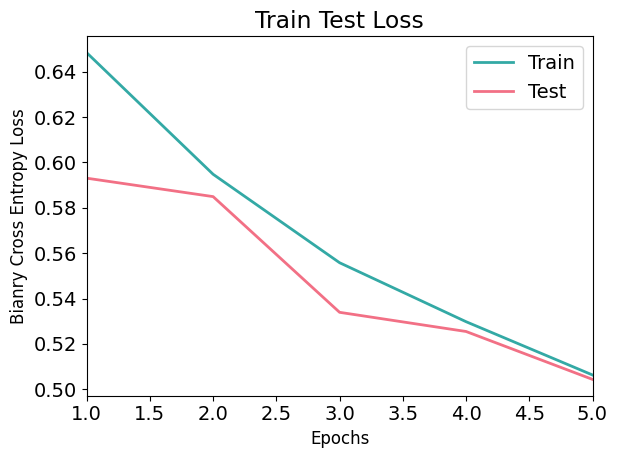

In [42]:
plot_train_test_losses(train_loss_history, val_loss_history)

In [43]:
batch = next(iter(valid_loader))
# print(len(batch))
s1_img = batch[0].to(DEVICE)
s2_img = batch[1].to(DEVICE)    
crop_map = batch[2].to(DEVICE)
print(f"s1_img.shape: {s1_img.shape}", f"s2_img.shape: {s2_img.shape}", f"crop_map.shape: {crop_map.shape}")
output = model(s1_img, s2_img)
print(f"output.shape: {output.shape}")

s1_img.shape: torch.Size([16, 2, 6, 64, 64]) s2_img.shape: torch.Size([16, 10, 6, 64, 64]) crop_map.shape: torch.Size([16, 1, 64, 64])
output.shape: torch.Size([16, 1, 64, 64])


In [66]:
INDEX_IN_BATCH = 1

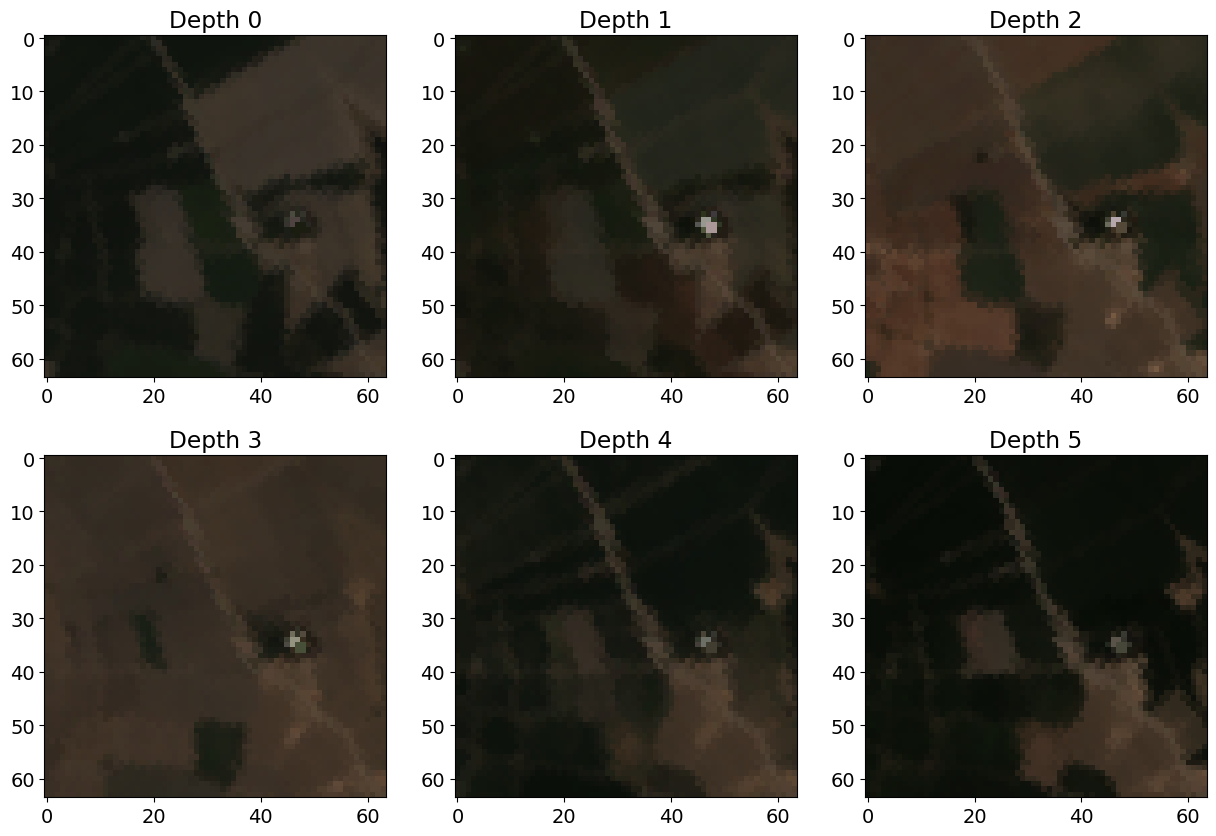

In [67]:
plot_s2_img(s2_img[INDEX_IN_BATCH],2,3)

In [68]:
# torch.sum(output, dim=1) # if all values are 1, then the softmax is working correctly

In [69]:
output_plot = output[INDEX_IN_BATCH].cpu().detach().numpy()
output_plot.shape

(1, 64, 64)

In [70]:
crop_map_plot = crop_map[INDEX_IN_BATCH].cpu().detach().numpy()
crop_map_plot.shape


(1, 64, 64)

In [71]:
output_plot.shape, crop_map_plot.shape

((1, 64, 64), (1, 64, 64))

In [72]:
# threshold = 0.3
# output_plot[output_plot >= threshold] = 1
# output_plot[output_plot < threshold] = 0

In [73]:
import importlib
import plot 
importlib.reload(plot)
from plot import plot_output_crop_map

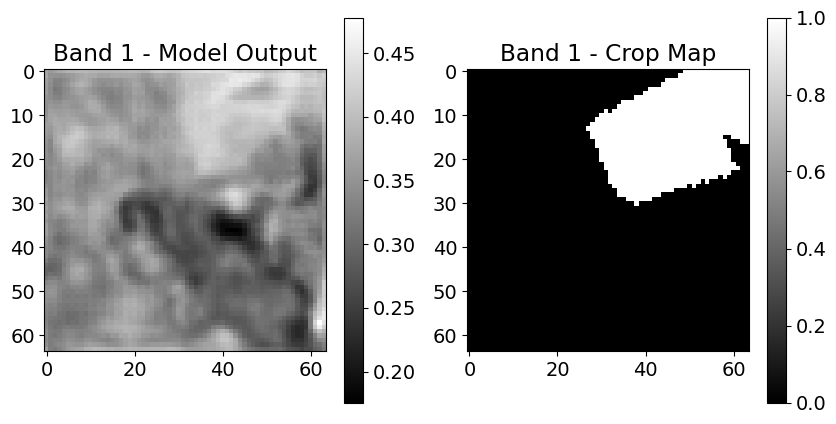

In [74]:
plot_output_crop_map(output_plot, crop_map_plot,colorbar=True)

In [65]:
binary_mask_accuracy(output.squeeze(), crop_map.squeeze(), threshold=0.30, channel=0)

{'accuracy': 0.33984375,
 'recall (true_positive_rate)': 0.9972118959107806,
 'true_negative_rate': 0.10562913907284768,
 'precision': 0.28431372549019607,
 'f1_score': 0.4424742268041237}

### Metrics for the whole dataset

In [54]:
eval_results = calculate_dataset_metrics({"train": train_loader, "valid": valid_loader}, model, threshold=0.3, channel=0)
eval_results

{'train': {'accuracy': 0.5052059618241947,
  'true_positive_rate (recall)': 0.9062099251782897,
  'true_negative_rate': 0.4274863792496115,
  'precision': 0.23475931643153888,
  'f1_score': 0.3729131598292136},
 'valid': {'accuracy': 0.49342202240566035,
  'true_positive_rate (recall)': 0.8373318978718665,
  'true_negative_rate': 0.4252452085215366,
  'precision': 0.22408838351850058,
  'f1_score': 0.3535571248305105}}

In [55]:
import json
# Specify the file path to save the JSON file
if IN_KAGGLE:
    file_path = "./results.json"
else:
    file_path = f"./model/results/results_epoch{NUM_EPOCH}_Tomato.json"

# Save the results dictionary as a JSON file
with open(file_path, "w") as file:
    json.dump(eval_results, file)
